<a href="https://colab.research.google.com/github/himavamsianumula/Cart-Pole/blob/master/cartpole_dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (49.6.0)


Libraries

In [19]:
import cv2
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from collections import namedtuple
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

In [3]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [4]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [5]:
env = wrap_env(gym.make("CartPole-v0"))
observation = env.reset()

while True:
    env.render()
    action = env.action_space.sample() 
    observation, reward, done, info = env.step(action)
    if done: 
      break;
          
env.close()
show_video()

Experience

In [6]:
Experience=namedtuple('Experience',('state','action', 'next_state', 'reward'))

In [7]:
a=[Experience(1,2,3,4),Experience(1,2,3,4)]
a[0][0]

1

DQN class


In [ ]:
class DQN1(tf.keras.Model):
  
  def __init__(self):
    super(DQN, self).__init__()
    self.flatten=tf.keras.layers.Flatten()
    self.dense1=tf.keras.layers.Dense(24,activation=tf.nn.relu)
    self.dense2=tf.keras.layers.Dense(32,activation=tf.nn.relu)
    self.out=tf.keras.layers.Dense(2,activation=tf.nn.relu)
  
  def call(self,inputs,training=False):
    x=self.flatten(inputs)
    x=self.dense2(self.dense1(x))
    return self.out(x)


In [28]:
def DQN_model(img_width,img_height):

  model=Sequential()

  model.add(Flatten())

  model.add(Dense(64))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(32))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(2))
  model.add(Activation('sigmoid'))

  model.compile(loss='binary_entropy',optimizer='Adam',metrics=['accuracy'])
  return model

In [29]:
mymodel=DQN_model(40,90)
#mymodel.summary()

Replay Memory class

In [9]:
class ReplayMemory:
  
  def __init__(self,size_limit):
    self.memory=[]
    self.size_limit=size_limit
    self.push_count=0

  def add_experience(self,Experience):
    if len(self.memory)<self.size_limit:
      self.memory.append(Experience)
    else:
      self.memory[self.push_count%self.size_limit]=Experience
    self.push_count+=1

  def get_sample(self,batch_size):
    if batch_size>len(self.memory):
      return []
    else:
      return random.sample(self.memory,batch_size)

In [10]:
rm=ReplayMemory(4)
rm.add_experience(Experience(2,2,2,1))
rm.add_experience(Experience(2,2,2,2))
rm.add_experience(Experience(2,2,2,3))
rm.add_experience(Experience(2,2,2,4))
rm.add_experience(Experience(2,2,2,5))
rm.get_sample(2)

[Experience(state=2, action=2, next_state=2, reward=3),
 Experience(state=2, action=2, next_state=2, reward=2)]

Agent class


In [12]:
class Agent(object):

  def __init__(self,n_actions,replay_memory,batch_size,eps_min,eps_max,eps_decay,learning_rate):
    
    self.n_actions=n_actions
    self.learning_rate=learning_rate

    self.replay_memory=replay_memory
    self.batch_size= batch_size

    self.eps_min=eps_min
    self.eps_max=eps_max
    self.eps_decay=eps_decay

    self.step=0
  
  def select_action(self,state):
    eps = self.get_epsilon()
    
    if eps> np.random.rand(1):
      return np.random.randint(0,n_actions)
    else:
      q_vals=self.dqn.predict(state.reshape(-1,self.input_shape[0],self.input_shape[1]))
      return np.argmax(q_vals)
  
  def get_epsilon(self):
    return self.eps_min + (self.eps_max - self.eps_min)*np.exp(-self.step*self.eps_decay)

  #def trainDQN(self,state,q_target):
  # self.trainDQN.compile(loss="mse",optimizer=Adam(lr=self.adam_lr))
  #  self.trainDQN.fit(state,q_target)
    
  #def update_targetDQN(self):
  #  self.targetDQN.set_weights(self.trainDQN.get_weights())

  def plot_mov_avg(self,episode_durations):
    pass

In [13]:
pass

Cart Pole Environment

In [14]:
class CartPoleEnv:
  def __init__(self):
    self.env=wrap_env(gym.make("CartPole-v0"))
    self.env.reset()
    self.done=False
    self.curr_screen=None
  
  def reset(self):
    self.env.reset()
    self.curr_screen=None
  
  def render(self,mode='human'):
    return self.env.render(mode)
    
  def close():
    self.env.close()

  def get_state(self):
    if self.done or self.at_start:
      self.curr_screen=self.process_frame()
      return np.zeros(self.curr_screen.shape)
    else:
      scr1=self.curr_screen
      scrn2=self.process_frame()
      self.curr_screen=scrn2
      return scrn2-scrn1
  
  def take_action(self,action):
    next_state,reward,self.done,info= self.env.step(action)
    return reward
  
  def at_start():
    if self.curr_screen is None:
      return True
    else:
      return False
  
  def process_frame(self,shape=(90,40)):

    frame=self.render('rgb_array')

    frame_height = frame.shape[1]
    top = int(frame_height * 0.2)
    bottom = int(frame_height * 0.7)

    frame = frame.astype(np.uint8)
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = frame[top:bottom,:]  # crop image
    frame = cv2.resize(frame, shape,interpolation=cv2.INTER_NEAREST)
    return frame
  
  def n_available_actions(self):
    return self.env.action_space.n

(40, 90, 3)


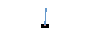

In [15]:
from google.colab.patches import cv2_imshow
env=CartPoleEnv()
env.reset()
#cv2_imshow(env.render('rgb_array'))
screen=env.process_frame()
print(screen.shape)
cv2_imshow(screen)

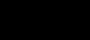

In [16]:
env.reset()
scrn=env.get_state()
cv2_imshow(scrn)

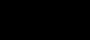

In [ ]:
env.reset()
for i in range(3):
  env.take_action(1)
scrn=env.get_state()
cv2_imshow(scrn)

Helper functions

In [ ]:
def extract(samples):
  l=[[],[],[],[]]
  for i in samples:
    l[0].append(i[0])
    l[1].append(i[1])
    l[2].append(i[2])
    l[3].append(i[3])
  return (l[0],l[1],l[2],l[3])

In [ ]:
samples=[Experience(1,1,1,1),Experience(2,2,2,2),Experience(3,3,3,3),Experience(4,4,4,4)]
list=extract(samples)
print(list)

([1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4])


Hyperparameters

In [ ]:
learning_rate=0.999
batch_size=256
eps_max=1
eps_min=0.01
eps_decay=0.001
update_targetDQN_iter=10
rm_capacity=100000
adam_lr=0.001
num_episodes=1000
input_shape=(40,90)

n_actions=CartPoleEnv().n_available_actions()
#print(n_actions)

Initializing objects

In [ ]:
env=CartPoleEnv()
trainDQN=DQN()
targetDQN=DQN()

rm=ReplayMemory(rm_capacity)
agent=Agent(n_actions,trainDQN,targetDQN,rm,batch_size,input_shape,eps_min,eps_max,eps_decay,learning_rate,adam_lr)
agent.update_targetDQN()

ValueError: ignored

Main Training Loop

In [ ]:
episode_durations=[]
for episode in range(num_episodes):
  env.reset()
  state=env.get_state()
  agent.step=0
  while env.done==False:
    a=agent.select_action(state)
    reward= env.take_action(a)
    next=env.get_state()
    rm.add_experience(Experience(state,a,next,reward))
    state=next
    sample=rm.get_sample(batch_size)
    if len(sample)!=0:
      states,actions,next_states,rewards=extract(sample)
      for s,a,ns,r in extract(sample):
        q_next=agent.targetDQN.predict(ns)
        q_target=r+ learning_rate*q_next
        agent.trainDQN(s,q_target)
    agent.step+=1
    if env.done:
      episode_durations.append(agent.step)

  if episode%update_targetDQN_iter==0:
    agent.update_targetDQN()

#env.close()

In [ ]:
print(episode_durations)

[16]
